In [20]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm


# Update the path to the correct location of your CSV file
pd.read_csv(r'C:\Users\joao_\Desktop\Data Science\Finance\market-mind\Notebooks\global_stock_companies.csv')

,ticker,name,sector,industry,country,market_cap,exchange,currency,last_updated
0,NEM,Newmont Corporation,Basic Materials,Gold,United States,9.945363e+10,NYQ,USD,2025-10-15 12:27:13.363825
1,BLK,"BlackRock, Inc.",Financial Services,Asset Management,United States,1.852297e+11,NYQ,USD,2025-10-15 12:27:14.455516
2,HST,"Host Hotels & Resorts, Inc.",Real Estate,REIT - Hotel & Motel,United States,1.140752e+10,NMS,USD,2025-10-15 12:27:15.513231
3,PNR,Pentair plc,Industrials,Specialty Industrial Machinery,United Kingdom,1.809965e+10,NYQ,USD,2025-10-15 12:27:16.775541
4,HCA,"HCA Healthcare, Inc.",Healthcare,Medical Care Facilities,United States,9.790288e+10,NYQ,USD,2025-10-15 12:27:17.825664
...,...,...,...,...,...,...,...,...,...
547,EMR,Emerson Electric Co.,Industrials,Specialty Industrial Machinery,United States,7.303456e+10,NYQ,USD,2025-10-15 12:38:24.648129
548,AWK,"American Water Works Company, Inc.",Utilities,Utilities - Regulated Water,United States,2.761815e+10,NYQ,USD,2025-10-15 12:38:25.887172
549,PM,Philip Morris International Inc.,Consumer Defensive,Tobacco,United States,2.476067e+11,NYQ,USD,2025-10-15 12:38:26.901208
550,PTC,PTC Inc.,Technology,Software - Application,United States,2.420531e+10,NMS,USD,2025-10-15 12:38:27.911761


In [21]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

class DataFetcher:
    def __init__(self, ticker_symbol):
        self.ticker_symbol = ticker_symbol
        self.ticker = yf.Ticker(ticker_symbol)

    def get_info(self):
        return self.ticker.info
        
    def get_income_statement(self):
        return self.ticker.income_stmt

    def get_balance_sheet(self):
        return self.ticker.balance_sheet

    def get_cash_flow(self):
        return self.ticker.cashflow

    def get_share_price_data(self, period="max"):
        share_price_data = self.ticker.history(period=period)
        share_price_data.reset_index(inplace=True)
        return share_price_data
    
    def calculate_pe_ratio(self, price, earnings_per_share):
        if earnings_per_share == 0 or earnings_per_share is None:
            return None
        return price / earnings_per_share

    def get_enhanced_income_statement(self):
        """Get income statement with share price, dividends, and P/E ratio"""
        try:
            info = self.ticker.info
            income_statement = self.ticker.income_stmt

            if income_statement is None or income_statement.empty:
                return None, None

            # Share price data
            share_price_data = self.get_share_price_data()
            
            # Add Share Price row
            share_prices = []
            for date_str in income_statement.columns:
                fiscal_date = pd.to_datetime(date_str).date()
                mask = share_price_data['Date'].dt.date <= fiscal_date
                if mask.any():
                    last_row = share_price_data[mask].iloc[-1]
                    share_prices.append(last_row['Close'])
                else:
                    share_prices.append(None)
            income_statement.loc['Share Price'] = share_prices

            # Add Dividends
            dividends = self.ticker.dividends.reset_index()
            if not dividends.empty:
                dividends['Date'] = pd.to_datetime(dividends['Date']).dt.date
                dividend_values = []
                for date_str in income_statement.columns:
                    fiscal_date = pd.to_datetime(date_str).date()
                    mask = dividends['Date'] <= fiscal_date
                    if mask.any():
                        last_div = dividends[mask].iloc[-1]['Dividends']
                        dividend_values.append(last_div)
                    else:
                        dividend_values.append(0.0)
            else:
                dividend_values = [0.0] * len(income_statement.columns)
            income_statement.loc['Dividends'] = dividend_values

            # Add P/E Ratio
            pe_ratios = []
            for col in income_statement.columns:
                share_price = income_statement.loc["Share Price", col]
                # Try different EPS column names
                eps = None
                for eps_col in ["Basic EPS", "Diluted EPS", "Earnings Per Share"]:
                    if eps_col in income_statement.index:
                        eps = income_statement.loc[eps_col, col]
                        break
                pe = self.calculate_pe_ratio(share_price, eps)
                pe_ratios.append(pe)
            income_statement.loc["P/E Ratio"] = pe_ratios

            return info, income_statement
            
        except Exception as e:
            print(f"Error processing {self.ticker_symbol}: {e}")
            return None, None

def create_income_statements_csv(csv_path, output_path=None, max_companies=None):
    """
    Create a CSV file with enhanced income statements for all companies
    
    Parameters:
    csv_path: Path to the companies CSV file
    output_path: Path where to save the income statements CSV
    max_companies: Limit number of companies to process (for testing)
    """
    # Load companies data
    companies_df = pd.read_csv(csv_path)
    
    if max_companies:
        companies_df = companies_df.head(max_companies)
    
    print(f"Processing {len(companies_df)} companies...")
    
    all_income_statements = []
    failed_tickers = []
    
    for _, company in tqdm(companies_df.iterrows(), total=len(companies_df), desc="Processing companies"):
        ticker = company['ticker']
        
        try:
            # Initialize data fetcher
            fetcher = DataFetcher(ticker)
            
            # Get enhanced income statement
            info, income_statement = fetcher.get_enhanced_income_statement()
            
            if income_statement is not None and not income_statement.empty:
                # Add company identifier to the income statement
                income_statement_with_meta = income_statement.copy()
                income_statement_with_meta.loc['Ticker'] = ticker
                income_statement_with_meta.loc['Company Name'] = company.get('name', '')
                income_statement_with_meta.loc['Sector'] = company.get('sector', '')
                income_statement_with_meta.loc['Industry'] = company.get('industry', '')
                
                all_income_statements.append(income_statement_with_meta)
            else:
                failed_tickers.append(ticker)
                
            # Rate limiting
            import time
            time.sleep(0.5)
            
        except Exception as e:
            failed_tickers.append(ticker)
            continue
    
    if all_income_statements:
        # Combine all income statements
        combined_income_statements = pd.concat(all_income_statements, axis=1)
        
        # Set output path
        if output_path is None:
            output_path = os.path.join(os.path.dirname(csv_path), 'all_income_statements.csv')
        
        # Save to CSV
        combined_income_statements.to_csv(output_path)
        print(f"\n✅ Successfully saved income statements for {len(all_income_statements)} companies to {output_path}")
    else:
        print("❌ No income statements were successfully retrieved")
    
    if failed_tickers:
        print(f"❌ Failed to retrieve data for {len(failed_tickers)} companies")
        print(f"Failed tickers: {failed_tickers[:10]}")  # Show first 10
    
    return combined_income_statements if all_income_statements else None

# Usage for your specific case:
def main():
    # Update the path to your CSV file
    csv_path = r'C:\Users\joao_\Desktop\Data Science\Finance\market-mind\Notebooks\global_stock_companies.csv'
    
    # Create output path in the same directory
    output_path = r'C:\Users\joao_\Desktop\Data Science\Finance\market-mind\Notebooks\all_income_statements.csv'
    
    # Process all companies (use max_companies=10 for testing)
    income_statements_df = create_income_statements_csv(
        csv_path=csv_path,
        output_path=output_path,
        max_companies=None  # Set to 10 for quick testing
    )
    
    if income_statements_df is not None:
        print(f"\nFinal dataset shape: {income_statements_df.shape}")
        print(f"Companies processed: {len(income_statements_df.columns)}")
        
        # Show sample of the data
        print("\nSample of the data:")
        print(income_statements_df.head())

# Run the main function
if __name__ == "__main__":
    main()

Processing 552 companies...


Processing companies: 100%|██████████| 552/552 [23:29<00:00,  2.55s/it]


✅ Successfully saved income statements for 547 companies to C:\Users\joao_\Desktop\Data Science\Finance\market-mind\Notebooks\all_income_statements.csv
❌ Failed to retrieve data for 5 companies
Failed tickers: ['BRK.B', 'DPW.DE', 'NOVOb.CO', 'DAI.DE', 'BF.B']

Final dataset shape: (91, 2587)
Companies processed: 2587

Sample of the data:
                                          2024-12-31    2023-12-31  \
Tax Effect Of Unusual Items             -342550000.0  -558390000.0   
Tax Rate For Calcs                              0.31          0.21   
Normalized EBITDA                       8633000000.0  2979000000.0   
Total Unusual Items                    -1105000000.0 -2659000000.0   
Total Unusual Items Excluding Goodwill -1105000000.0 -2659000000.0   

                                          2022-12-31    2021-12-31 2020-12-31  \
Tax Effect Of Unusual Items             -319830000.0  -167670000.0        NaN   
Tax Rate For Calcs                              0.21          0.27        Na

In [694]:
# Simple usage:
csv_path = r'C:\Users\joao_\Desktop\Data Science\Finance\market-mind\Notebooks\all_income_statements.csv'
companies_df=pd.read_csv(csv_path)
companies_df.tail()  # Display the first few rows


,Unnamed: 0,2024-12-31,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2024-12-31.1,2023-12-31.1,2022-12-31.1,2021-12-31.1,...,2020-12-31.340,2024-09-30.25,2023-09-30.25,2022-09-30.25,2021-09-30.25,2024-12-31.427,2023-12-31.427,2022-12-31.427,2021-12-31.426,2020-12-31.341
86,Excise Taxes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,Securities Amortization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,Depletion Income Statement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,Net Income From Tax Loss Carryforward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,Net Income Extraordinary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [695]:
import numpy as np
# Check if any cell contains a ticker (like 'AAPL', 'MSFT', etc.)
ticker_patterns = ['AAPL', 'MSFT', 'GOOGL', 'Ticker']  # Add common tickers
for pattern in ticker_patterns:
    mask = companies_df.astype(str).apply(lambda x: x.str.contains(pattern, na=False))
    if mask.any().any():
        print(f"Found '{pattern}' in the data")
        # Show where it was found
        locations = np.where(mask)
        for row, col in zip(locations[0][:3], locations[1][:3]):  # Show first 3 occurrences
            print(f"  Row {row}, Column {companies_df.columns[col]}")

Found 'AAPL' in the data
  Row 58, Column 2024-09-30.15
  Row 58, Column 2023-09-30.15
  Row 58, Column 2022-09-30.15
Found 'MSFT' in the data
  Row 58, Column 2025-06-30.12
  Row 58, Column 2024-06-30.12
  Row 58, Column 2023-06-30.12
Found 'GOOGL' in the data
  Row 58, Column 2024-12-31.258
  Row 58, Column 2023-12-31.258
  Row 58, Column 2022-12-31.258
Found 'Ticker' in the data
  Row 58, Column Unnamed: 0


In [696]:
# Check data types
print("Data types:")
print(companies_df.dtypes.value_counts())

# Let's see what's in the first column (likely row labels)
print("\nSample from first column:")
print(companies_df.iloc[:, 0].head(15))

Data types:
object    2588
Name: count, dtype: int64

Sample from first column:
0                           Tax Effect Of Unusual Items
1                                    Tax Rate For Calcs
2                                     Normalized EBITDA
3                                   Total Unusual Items
4                Total Unusual Items Excluding Goodwill
5     Net Income From Continuing Operation Net Minor...
6                               Reconciled Depreciation
7                            Reconciled Cost Of Revenue
8                                                EBITDA
9                                                  EBIT
10                                  Net Interest Income
11                                     Interest Expense
12                                      Interest Income
13                                    Normalized Income
14    Net Income From Continuing And Discontinued Op...
Name: Unnamed: 0, dtype: object


In [697]:
# Check if we have ticker information
first_col = companies_df.iloc[:, 0].astype(str)
has_ticker = 'Ticker' in first_col.values
print("Has 'Ticker' row:", has_ticker)

if has_ticker:
    ticker_row = companies_df[first_col == 'Ticker']
    print("\nTicker row data:")
    print(ticker_row.iloc[:, :5])  # First 5 columns

Has 'Ticker' row: True

Ticker row data:
   Unnamed: 0 2024-12-31 2023-12-31 2022-12-31 2021-12-31
58     Ticker        NEM        NEM        NEM        NEM


In [698]:
# Let's try to convert to numeric and see basic stats
numeric_check = companies_df.apply(pd.to_numeric, errors='coerce')

print("Numeric columns summary:")
print(f"Total numeric columns: {numeric_check.shape[1]}")
print(f"Total numeric values: {numeric_check.count().sum()}")

# Show basic stats for first few numeric columns that have data
numeric_cols_with_data = numeric_check.columns[numeric_check.count() > 0]
if len(numeric_cols_with_data) > 0:
    print("\nBasic stats for first 5 numeric columns:")
    print(numeric_check[numeric_cols_with_data[:5]].describe())

Numeric columns summary:
Total numeric columns: 2588
Total numeric values: 109093

Basic stats for first 5 numeric columns:
         2024-12-31    2023-12-31    2022-12-31    2021-12-31    2020-12-31
count  5.500000e+01  5.600000e+01  5.600000e+01  5.700000e+01  5.000000e+00
mean   2.619925e+09  6.931646e+08  1.145185e+09  1.468976e+09  3.700001e+07
std    4.569777e+09  3.430058e+09  3.086559e+09  2.959852e+09  5.066556e+07
min   -1.268000e+09 -2.659000e+09 -1.523000e+09 -6.320000e+08  0.000000e+00
25%    7.745247e+00 -4.548900e+08 -8.225000e+07  1.460000e+00  4.000000e-01
50%    4.420000e+08  7.500020e+06  5.650000e+07  2.590000e+08  5.129292e+01
75%    3.348000e+09  5.715000e+08  7.942500e+08  1.166000e+09  9.200000e+07
max    1.868200e+10  1.181200e+10  1.191500e+10  1.222200e+10  9.300000e+07


In [699]:
companies_df.head()

,Unnamed: 0,2024-12-31,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2024-12-31.1,2023-12-31.1,2022-12-31.1,2021-12-31.1,...,2020-12-31.340,2024-09-30.25,2023-09-30.25,2022-09-30.25,2021-09-30.25,2024-12-31.427,2023-12-31.427,2022-12-31.427,2021-12-31.426,2020-12-31.341
0,Tax Effect Of Unusual Items,-342550000.0,-558390000.0,-319830000.0,-167670000.0,NaN,115632000.0,135892000.0,-25200000.0,202506790.652147,...,NaN,160400.0,119600.0,-7666298.943838,-594000.0,49245000.0,0.0,0.0,-4851000.0,NaN
1,Tax Rate For Calcs,0.31,0.21,0.21,0.27,NaN,0.219,0.212,0.2,0.240793,...,NaN,0.2,0.26,0.211577,0.27,0.245,0.223,0.225,0.231,NaN
2,Normalized EBITDA,8633000000.0,2979000000.0,3884000000.0,4326000000.0,NaN,8834000000.0,7233000000.0,7046000000.0,7952000000.0,...,NaN,729220000.0,598685000.0,609640000.0,566967000.0,NaN,NaN,NaN,NaN,NaN
3,Total Unusual Items,-1105000000.0,-2659000000.0,-1523000000.0,-621000000.0,NaN,528000000.0,641000000.0,-126000000.0,841000000.0,...,NaN,802000.0,460000.0,-36234000.0,-2200000.0,201000000.0,0.0,0.0,-21000000.0,NaN
4,Total Unusual Items Excluding Goodwill,-1105000000.0,-2659000000.0,-1523000000.0,-621000000.0,NaN,528000000.0,641000000.0,-126000000.0,841000000.0,...,NaN,802000.0,460000.0,-36234000.0,-2200000.0,201000000.0,0.0,0.0,-21000000.0,NaN


In [700]:
# Find which row contains 'Ticker'
first_col = companies_df.iloc[:, 0].astype(str)
ticker_row_index = first_col[first_col == 'Ticker'].index

if len(ticker_row_index) > 0:
    print(f"Found 'Ticker' row at index: {ticker_row_index[0]}")
else:
    print("No 'Ticker' row found in the first column")
    # Let's search the entire dataframe
    for idx, row in companies_df.iterrows():
        if any('Ticker' in str(cell) for cell in row):
            print(f"Found 'Ticker' at row index: {idx}")
            ticker_row_index = [idx]
            break

Found 'Ticker' row at index: 58


In [701]:
# Step 1: Get the ticker row at index 58
ticker_row = companies_df.iloc[58]

# Step 2: Remove the ticker row from its current position
companies_df_clean = companies_df.drop(58)

# Step 3: Add the ticker row back at the top (position 0)
companies_df = pd.concat([pd.DataFrame([ticker_row]), companies_df_clean], ignore_index=True)

print("✅ Ticker row moved from position 58 to the top!")

✅ Ticker row moved from position 58 to the top!


In [702]:
# Step 4: Verify the move worked
print("First 5 rows after moving ticker:")
companies_df.head()

First 5 rows after moving ticker:


,Unnamed: 0,2024-12-31,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2024-12-31.1,2023-12-31.1,2022-12-31.1,2021-12-31.1,...,2020-12-31.340,2024-09-30.25,2023-09-30.25,2022-09-30.25,2021-09-30.25,2024-12-31.427,2023-12-31.427,2022-12-31.427,2021-12-31.426,2020-12-31.341
0,Ticker,NEM,NEM,NEM,NEM,NEM,BLK,BLK,BLK,BLK,...,PM,PTC,PTC,PTC,PTC,ELV,ELV,ELV,ELV,ELV
1,Tax Effect Of Unusual Items,-342550000.0,-558390000.0,-319830000.0,-167670000.0,NaN,115632000.0,135892000.0,-25200000.0,202506790.652147,...,NaN,160400.0,119600.0,-7666298.943838,-594000.0,49245000.0,0.0,0.0,-4851000.0,NaN
2,Tax Rate For Calcs,0.31,0.21,0.21,0.27,NaN,0.219,0.212,0.2,0.240793,...,NaN,0.2,0.26,0.211577,0.27,0.245,0.223,0.225,0.231,NaN
3,Normalized EBITDA,8633000000.0,2979000000.0,3884000000.0,4326000000.0,NaN,8834000000.0,7233000000.0,7046000000.0,7952000000.0,...,NaN,729220000.0,598685000.0,609640000.0,566967000.0,NaN,NaN,NaN,NaN,NaN
4,Total Unusual Items,-1105000000.0,-2659000000.0,-1523000000.0,-621000000.0,NaN,528000000.0,641000000.0,-126000000.0,841000000.0,...,NaN,802000.0,460000.0,-36234000.0,-2200000.0,201000000.0,0.0,0.0,-21000000.0,NaN


In [703]:
# Create new column names
current_headers = companies_df.columns.tolist()
new_columns = [f'DataPoint{i+1}' for i in range(len(companies_df.columns))]
companies_df.columns = new_columns

print("✅ Columns renamed!")
print("New column names (first 10):")
companies_df.head()

✅ Columns renamed!
New column names (first 10):


,DataPoint1,DataPoint2,DataPoint3,DataPoint4,DataPoint5,DataPoint6,DataPoint7,DataPoint8,DataPoint9,DataPoint10,...,DataPoint2579,DataPoint2580,DataPoint2581,DataPoint2582,DataPoint2583,DataPoint2584,DataPoint2585,DataPoint2586,DataPoint2587,DataPoint2588
0,Ticker,NEM,NEM,NEM,NEM,NEM,BLK,BLK,BLK,BLK,...,PM,PTC,PTC,PTC,PTC,ELV,ELV,ELV,ELV,ELV
1,Tax Effect Of Unusual Items,-342550000.0,-558390000.0,-319830000.0,-167670000.0,NaN,115632000.0,135892000.0,-25200000.0,202506790.652147,...,NaN,160400.0,119600.0,-7666298.943838,-594000.0,49245000.0,0.0,0.0,-4851000.0,NaN
2,Tax Rate For Calcs,0.31,0.21,0.21,0.27,NaN,0.219,0.212,0.2,0.240793,...,NaN,0.2,0.26,0.211577,0.27,0.245,0.223,0.225,0.231,NaN
3,Normalized EBITDA,8633000000.0,2979000000.0,3884000000.0,4326000000.0,NaN,8834000000.0,7233000000.0,7046000000.0,7952000000.0,...,NaN,729220000.0,598685000.0,609640000.0,566967000.0,NaN,NaN,NaN,NaN,NaN
4,Total Unusual Items,-1105000000.0,-2659000000.0,-1523000000.0,-621000000.0,NaN,528000000.0,641000000.0,-126000000.0,841000000.0,...,NaN,802000.0,460000.0,-36234000.0,-2200000.0,201000000.0,0.0,0.0,-21000000.0,NaN


In [704]:
# Create a new row with the original dates

date_row_data = ['Date'] + current_headers[1:]  # Keep first column name for the index

# Add this as a new row at the top
date_row_df = pd.DataFrame([date_row_data], columns=companies_df.columns)
companies_df = pd.concat([date_row_df, companies_df], ignore_index=True)

print("✅ Date row added!")

✅ Date row added!


In [705]:
companies_df.head()

,DataPoint1,DataPoint2,DataPoint3,DataPoint4,DataPoint5,DataPoint6,DataPoint7,DataPoint8,DataPoint9,DataPoint10,...,DataPoint2579,DataPoint2580,DataPoint2581,DataPoint2582,DataPoint2583,DataPoint2584,DataPoint2585,DataPoint2586,DataPoint2587,DataPoint2588
0,Date,2024-12-31,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2024-12-31.1,2023-12-31.1,2022-12-31.1,2021-12-31.1,...,2020-12-31.340,2024-09-30.25,2023-09-30.25,2022-09-30.25,2021-09-30.25,2024-12-31.427,2023-12-31.427,2022-12-31.427,2021-12-31.426,2020-12-31.341
1,Ticker,NEM,NEM,NEM,NEM,NEM,BLK,BLK,BLK,BLK,...,PM,PTC,PTC,PTC,PTC,ELV,ELV,ELV,ELV,ELV
2,Tax Effect Of Unusual Items,-342550000.0,-558390000.0,-319830000.0,-167670000.0,NaN,115632000.0,135892000.0,-25200000.0,202506790.652147,...,NaN,160400.0,119600.0,-7666298.943838,-594000.0,49245000.0,0.0,0.0,-4851000.0,NaN
3,Tax Rate For Calcs,0.31,0.21,0.21,0.27,NaN,0.219,0.212,0.2,0.240793,...,NaN,0.2,0.26,0.211577,0.27,0.245,0.223,0.225,0.231,NaN
4,Normalized EBITDA,8633000000.0,2979000000.0,3884000000.0,4326000000.0,NaN,8834000000.0,7233000000.0,7046000000.0,7952000000.0,...,NaN,729220000.0,598685000.0,609640000.0,566967000.0,NaN,NaN,NaN,NaN,NaN


In [706]:
# Use the second column (DataPoint1) as the new index
companies_df = companies_df.set_index('DataPoint1')
companies_df.index.name = 'Financial Metric'

print("✅ Second column set as index!")
print("New index values (first 10):")
print(companies_df.index[:10].values)

✅ Second column set as index!
New index values (first 10):
['Date' 'Ticker' 'Tax Effect Of Unusual Items' 'Tax Rate For Calcs'
 'Normalized EBITDA' 'Total Unusual Items'
 'Total Unusual Items Excluding Goodwill'
 'Net Income From Continuing Operation Net Minority Interest'
 'Reconciled Depreciation' 'Reconciled Cost Of Revenue']


In [707]:
print("✅ Structure is correct!")
print(f"Index (row names): {len(companies_df.index)} rows")
print(f"Columns (datapoints): {len(companies_df.columns)} columns")
print(f"Index name: '{companies_df.index.name}'")
print("Date row (first 10 datapoints):")
print(companies_df.loc['Date'].head(10))
print("\nTicker row (first 10 datapoints):")
print(companies_df.loc['Ticker'].head(10))


✅ Structure is correct!
Index (row names): 92 rows
Columns (datapoints): 2587 columns
Index name: 'Financial Metric'
Date row (first 10 datapoints):
DataPoint2       2024-12-31
DataPoint3       2023-12-31
DataPoint4       2022-12-31
DataPoint5       2021-12-31
DataPoint6       2020-12-31
DataPoint7     2024-12-31.1
DataPoint8     2023-12-31.1
DataPoint9     2022-12-31.1
DataPoint10    2021-12-31.1
DataPoint11    2020-12-31.1
Name: Date, dtype: object

Ticker row (first 10 datapoints):
DataPoint2     NEM
DataPoint3     NEM
DataPoint4     NEM
DataPoint5     NEM
DataPoint6     NEM
DataPoint7     BLK
DataPoint8     BLK
DataPoint9     BLK
DataPoint10    BLK
DataPoint11    BLK
Name: Ticker, dtype: object


In [708]:
companies_df.head()


,DataPoint2,DataPoint3,DataPoint4,DataPoint5,DataPoint6,DataPoint7,DataPoint8,DataPoint9,DataPoint10,DataPoint11,...,DataPoint2579,DataPoint2580,DataPoint2581,DataPoint2582,DataPoint2583,DataPoint2584,DataPoint2585,DataPoint2586,DataPoint2587,DataPoint2588
Financial Metric,,,,,,,,,,,,,,,,,,,,,
Date,2024-12-31,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2024-12-31.1,2023-12-31.1,2022-12-31.1,2021-12-31.1,2020-12-31.1,...,2020-12-31.340,2024-09-30.25,2023-09-30.25,2022-09-30.25,2021-09-30.25,2024-12-31.427,2023-12-31.427,2022-12-31.427,2021-12-31.426,2020-12-31.341
Ticker,NEM,NEM,NEM,NEM,NEM,BLK,BLK,BLK,BLK,BLK,...,PM,PTC,PTC,PTC,PTC,ELV,ELV,ELV,ELV,ELV
Tax Effect Of Unusual Items,-342550000.0,-558390000.0,-319830000.0,-167670000.0,NaN,115632000.0,135892000.0,-25200000.0,202506790.652147,NaN,...,NaN,160400.0,119600.0,-7666298.943838,-594000.0,49245000.0,0.0,0.0,-4851000.0,NaN
Tax Rate For Calcs,0.31,0.21,0.21,0.27,NaN,0.219,0.212,0.2,0.240793,NaN,...,NaN,0.2,0.26,0.211577,0.27,0.245,0.223,0.225,0.231,NaN
Normalized EBITDA,8633000000.0,2979000000.0,3884000000.0,4326000000.0,NaN,8834000000.0,7233000000.0,7046000000.0,7952000000.0,NaN,...,NaN,729220000.0,598685000.0,609640000.0,566967000.0,NaN,NaN,NaN,NaN,NaN


Number of unique tickers: 547
First 20 unique tickers:
['NEM' 'BLK' 'HST' 'PNR' 'HCA' 'JBHT' 'NTRS' 'ULTA' 'RVTY' 'PAYX' 'PSKY'
 'MRNA' 'TDY' 'EXR' 'ITX.MC' 'MCD' 'TECH' 'BA' 'EXC' 'ADI']
Number of datapoints per ticker (top 20):
Ticker
NEM     5
NOW     5
UDR     5
KEY     5
D       5
VTR     5
UNP     5
CPT     5
AKAM    5
MKTX    5
GL      5
MRK     5
HAL     5
LMT     5
IDXX    5
SCHW    5
PPG     5
DVA     5
KIM     5
ARE     5
Name: count, dtype: int64


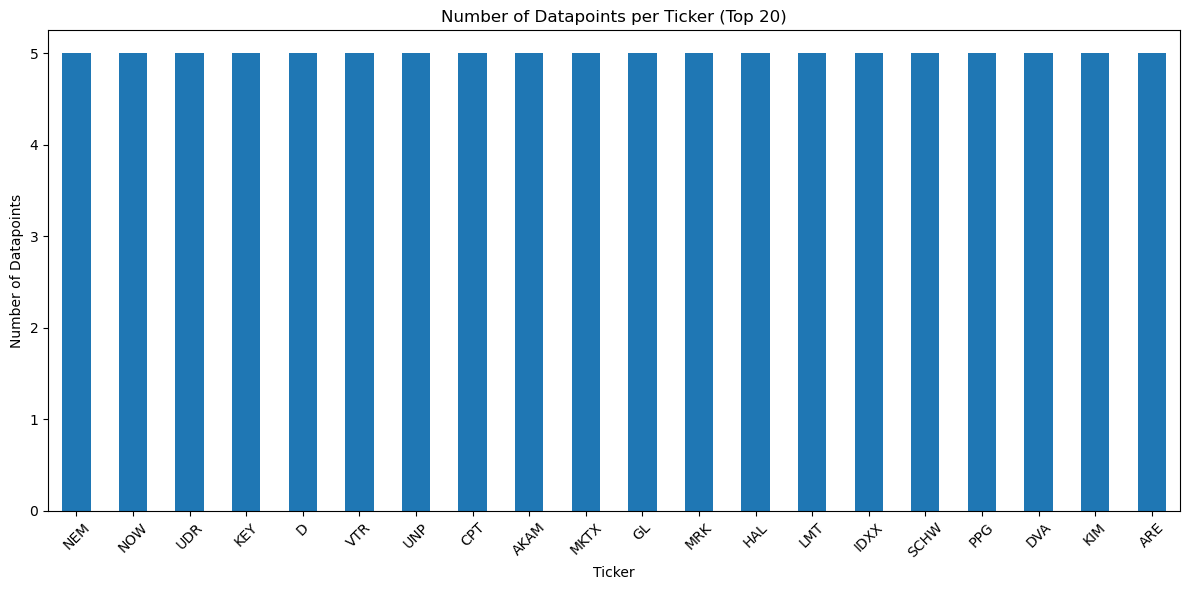

In [709]:
# Get all unique tickers from the Ticker row
all_tickers = companies_df.loc['Ticker'].unique()
print(f"Number of unique tickers: {len(all_tickers)}")
print("First 20 unique tickers:")
print(all_tickers[:20])
# Count how many datapoints belong to each ticker
ticker_counts = companies_df.loc['Ticker'].value_counts()
print("Number of datapoints per ticker (top 20):")
print(ticker_counts.head(20))
# Visualize the distribution
plt.figure(figsize=(12, 6))
ticker_counts.head(20).plot(kind='bar')
plt.title('Number of Datapoints per Ticker (Top 20)')
plt.xlabel('Ticker')
plt.ylabel('Number of Datapoints')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [710]:
# Let's see the dates for a specific ticker (e.g., NEM)
nem_dates = companies_df.loc['Date', companies_df.loc['Ticker'] == 'NEM']
print("Dates for NEM ticker:")
print(nem_dates.head(10))

Dates for NEM ticker:
DataPoint2    2024-12-31
DataPoint3    2023-12-31
DataPoint4    2022-12-31
DataPoint5    2021-12-31
DataPoint6    2020-12-31
Name: Date, dtype: object


In [711]:
# Count unique dates per ticker
ticker_date_counts = {}
for ticker in all_tickers[:10]:  # Check first 10 tickers
    ticker_dates = companies_df.loc['Date', companies_df.loc['Ticker'] == ticker]
    unique_dates = ticker_dates.unique()
    ticker_date_counts[ticker] = len(unique_dates)
    print(f"{ticker}: {len(unique_dates)} unique dates")

print(f"\nAverage years of data per ticker: {np.mean(list(ticker_date_counts.values())):.1f}")

NEM: 5 unique dates
BLK: 5 unique dates
HST: 5 unique dates
PNR: 5 unique dates
HCA: 5 unique dates
JBHT: 4 unique dates
NTRS: 5 unique dates
ULTA: 5 unique dates
RVTY: 5 unique dates
PAYX: 4 unique dates

Average years of data per ticker: 4.8


In [712]:
# Show all data for one specific ticker (e.g., NEM)
nem_columns = companies_df.loc['Ticker'] == 'NEM'
print(f"NEM has {nem_columns.sum()} datapoints")
print("\nDates for NEM:")
print(companies_df.loc['Date', nem_columns].values)

NEM has 5 datapoints

Dates for NEM:
['2024-12-31' '2023-12-31' '2022-12-31' '2021-12-31' '2020-12-31']


In [713]:
# Get the ticker row
ticker_row = companies_df.loc['Ticker']

# Find where tickers change
ticker_changes = ticker_row.ne(ticker_row.shift())
change_indices = ticker_changes[ticker_changes].index

print("Ticker change points (first 10):")
for idx in change_indices[:10]:
    print(f"{idx}: {ticker_row[idx]}")

Ticker change points (first 10):
DataPoint2: NEM
DataPoint7: BLK
DataPoint12: HST
DataPoint17: PNR
DataPoint22: HCA
DataPoint27: JBHT
DataPoint31: NTRS
DataPoint36: ULTA
DataPoint41: RVTY
DataPoint46: PAYX


In [714]:
# Create new column names that reset for each ticker (without ticker name)
new_columns = []
current_ticker = None
ticker_counter = 1

for col in companies_df.columns:
    ticker = ticker_row[col]
    
    if ticker != current_ticker:
        # New ticker, reset counter
        current_ticker = ticker
        ticker_counter = 1
        new_columns.append(f"DataPoint1")
    else:
        # Same ticker, increment counter
        ticker_counter += 1
        new_columns.append(f"DataPoint{ticker_counter}")

print("New column names (first 20):")
print(new_columns[:20])

New column names (first 20):
['DataPoint1', 'DataPoint2', 'DataPoint3', 'DataPoint4', 'DataPoint5', 'DataPoint1', 'DataPoint2', 'DataPoint3', 'DataPoint4', 'DataPoint5', 'DataPoint1', 'DataPoint2', 'DataPoint3', 'DataPoint4', 'DataPoint5', 'DataPoint1', 'DataPoint2', 'DataPoint3', 'DataPoint4', 'DataPoint5']


In [715]:
# Apply the new column names
companies_df_renamed = companies_df.copy()
companies_df_renamed.columns = new_columns
companies_df = companies_df_renamed

print("✅ Columns renamed with ticker-specific numbering!")
print(f"New shape: {companies_df.shape}")

✅ Columns renamed with ticker-specific numbering!
New shape: (92, 2587)


In [716]:
print("New structure (first 20 columns):")
print(companies_df.columns[:20].tolist())

New structure (first 20 columns):
['DataPoint1', 'DataPoint2', 'DataPoint3', 'DataPoint4', 'DataPoint5', 'DataPoint1', 'DataPoint2', 'DataPoint3', 'DataPoint4', 'DataPoint5', 'DataPoint1', 'DataPoint2', 'DataPoint3', 'DataPoint4', 'DataPoint5', 'DataPoint1', 'DataPoint2', 'DataPoint3', 'DataPoint4', 'DataPoint5']


In [717]:
companies_df.head()

,DataPoint1,DataPoint2,DataPoint3,DataPoint4,DataPoint5,DataPoint1,DataPoint2,DataPoint3,DataPoint4,DataPoint5,...,DataPoint5,DataPoint1,DataPoint2,DataPoint3,DataPoint4,DataPoint1,DataPoint2,DataPoint3,DataPoint4,DataPoint5
Financial Metric,,,,,,,,,,,,,,,,,,,,,
Date,2024-12-31,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2024-12-31.1,2023-12-31.1,2022-12-31.1,2021-12-31.1,2020-12-31.1,...,2020-12-31.340,2024-09-30.25,2023-09-30.25,2022-09-30.25,2021-09-30.25,2024-12-31.427,2023-12-31.427,2022-12-31.427,2021-12-31.426,2020-12-31.341
Ticker,NEM,NEM,NEM,NEM,NEM,BLK,BLK,BLK,BLK,BLK,...,PM,PTC,PTC,PTC,PTC,ELV,ELV,ELV,ELV,ELV
Tax Effect Of Unusual Items,-342550000.0,-558390000.0,-319830000.0,-167670000.0,NaN,115632000.0,135892000.0,-25200000.0,202506790.652147,NaN,...,NaN,160400.0,119600.0,-7666298.943838,-594000.0,49245000.0,0.0,0.0,-4851000.0,NaN
Tax Rate For Calcs,0.31,0.21,0.21,0.27,NaN,0.219,0.212,0.2,0.240793,NaN,...,NaN,0.2,0.26,0.211577,0.27,0.245,0.223,0.225,0.231,NaN
Normalized EBITDA,8633000000.0,2979000000.0,3884000000.0,4326000000.0,NaN,8834000000.0,7233000000.0,7046000000.0,7952000000.0,NaN,...,NaN,729220000.0,598685000.0,609640000.0,566967000.0,NaN,NaN,NaN,NaN,NaN


In [718]:
# Function to extract year from date string
def extract_year(date_str):
    if pd.isna(date_str):
        return None
    # Handle different date formats (YYYY-MM-DD, YYYY-MM-DD.X, etc.)
    date_str = str(date_str)
    # Extract the first 4 characters (the year)
    if len(date_str) >= 4 and date_str[:4].isdigit():
        return int(date_str[:4])
    else:
        return None

# Apply the function to all dates
cleaned_dates = companies_df.loc['Date'].apply(extract_year)

In [719]:
# Replace the Date row with just years
companies_df.loc['Date'] = cleaned_dates

print("✅ Dates converted to years only!")

✅ Dates converted to years only!


In [720]:
print("Dates after cleaning (first 30):")
print(companies_df.loc['Date'].head(30).values)

Dates after cleaning (first 30):
[2024 2023 2022 2021 2020 2024 2023 2022 2021 2020 2024 2023 2022 2021
 2020 2024 2023 2022 2021 2020 2024 2023 2022 2021 2020 2024 2023 2022
 2021 2024]


In [721]:
companies_df.head()

,DataPoint1,DataPoint2,DataPoint3,DataPoint4,DataPoint5,DataPoint1,DataPoint2,DataPoint3,DataPoint4,DataPoint5,...,DataPoint5,DataPoint1,DataPoint2,DataPoint3,DataPoint4,DataPoint1,DataPoint2,DataPoint3,DataPoint4,DataPoint5
Financial Metric,,,,,,,,,,,,,,,,,,,,,
Date,2024,2023,2022,2021,2020,2024,2023,2022,2021,2020,...,2020,2024,2023,2022,2021,2024,2023,2022,2021,2020
Ticker,NEM,NEM,NEM,NEM,NEM,BLK,BLK,BLK,BLK,BLK,...,PM,PTC,PTC,PTC,PTC,ELV,ELV,ELV,ELV,ELV
Tax Effect Of Unusual Items,-342550000.0,-558390000.0,-319830000.0,-167670000.0,NaN,115632000.0,135892000.0,-25200000.0,202506790.652147,NaN,...,NaN,160400.0,119600.0,-7666298.943838,-594000.0,49245000.0,0.0,0.0,-4851000.0,NaN
Tax Rate For Calcs,0.31,0.21,0.21,0.27,NaN,0.219,0.212,0.2,0.240793,NaN,...,NaN,0.2,0.26,0.211577,0.27,0.245,0.223,0.225,0.231,NaN
Normalized EBITDA,8633000000.0,2979000000.0,3884000000.0,4326000000.0,NaN,8834000000.0,7233000000.0,7046000000.0,7952000000.0,NaN,...,NaN,729220000.0,598685000.0,609640000.0,566967000.0,NaN,NaN,NaN,NaN,NaN


In [722]:
global_stock_df = pd.read_csv(r'C:\Users\joao_\Desktop\Data Science\Finance\market-mind\Notebooks\global_stock_companies.csv')
global_stock_df.head()

,ticker,name,sector,industry,country,market_cap,exchange,currency,last_updated
0,NEM,Newmont Corporation,Basic Materials,Gold,United States,9.945363e+10,NYQ,USD,2025-10-15 12:27:13.363825
1,BLK,"BlackRock, Inc.",Financial Services,Asset Management,United States,1.852297e+11,NYQ,USD,2025-10-15 12:27:14.455516
2,HST,"Host Hotels & Resorts, Inc.",Real Estate,REIT - Hotel & Motel,United States,1.140752e+10,NMS,USD,2025-10-15 12:27:15.513231
3,PNR,Pentair plc,Industrials,Specialty Industrial Machinery,United Kingdom,1.809965e+10,NYQ,USD,2025-10-15 12:27:16.775541
4,HCA,"HCA Healthcare, Inc.",Healthcare,Medical Care Facilities,United States,9.790288e+10,NYQ,USD,2025-10-15 12:27:17.825664


In [723]:
# Simple pivot table counting companies per sector
sector_pivot = pd.pivot_table(global_stock_df,
                             index='sector',
                             values='ticker',
                             aggfunc='count',
                             sort=True)

print("Companies per sector:")
sector_pivot

Companies per sector:


,ticker
sector,
Basic Materials,23
Communication Services,25
Consumer Cyclical,62
Consumer Defensive,41
Energy,24
Financial Services,77
Healthcare,68
Industrials,75
Real Estate,31


In [724]:
# Create a clean table with Sector and Ticker columns
sector_ticker_df = global_stock_df[['sector', 'ticker']].copy()
sector_ticker_df = sector_ticker_df.sort_values('sector')

print("Sector-Ticker table:")
print(sector_ticker_df.head(20))

Sector-Ticker table:
              sector  ticker
0    Basic Materials     NEM
523  Basic Materials     NUE
38   Basic Materials     ALB
514  Basic Materials  HEI.DE
483  Basic Materials     LYB
96   Basic Materials    CTVA
103  Basic Materials     MOS
456  Basic Materials     VMC
450  Basic Materials      DD
135  Basic Materials     MLM
406  Basic Materials      CF
179  Basic Materials     IFF
203  Basic Materials     FCX
349  Basic Materials    STLD
224  Basic Materials  BAS.DE
226  Basic Materials     EMN
231  Basic Materials     LIN
328  Basic Materials     PPG
315  Basic Materials   AI.PA
254  Basic Materials     SHW


In [725]:
# Group by sector and aggregate tickers into lists
sector_companies_df = global_stock_df.groupby('sector')['ticker'].apply(list).reset_index()

print("Sectors with company lists:")
print(sector_companies_df)

Sectors with company lists:
                    sector                                             ticker
0          Basic Materials  [NEM, APD, ECL, ALB, CTVA, MOS, MLM, IFF, FCX,...
1   Communication Services  [PSKY, TMUS, NWSA, LYV, CHTR, META, TTD, TKO, ...
2        Consumer Cyclical  [ULTA, ITX.MC, MCD, KMX, SBUX, RL, AZO, HAS, S...
3       Consumer Defensive  [DG, MKC, WMT, KVUE, MO, LW, ABI.BR, TAP, TGT,...
4                   Energy  [TPL, ENI.MI, EXE, BKR, REP.MC, DVN, EQT, OXY,...
5       Financial Services  [BLK, NTRS, WTW, ACGL, RF, AMP, ERIE, ALV.DE, ...
6               Healthcare  [HCA, RVTY, MRNA, TECH, VTRS, BDX, MCK, BIIB, ...
7              Industrials  [PNR, JBHT, BA, HII, AME, XYL, SNA, VLTO, PWR,...
8              Real Estate  [HST, EXR, FRT, O, DLR, PSA, REG, VICI, AVB, E...
9               Technology  [PAYX, TDY, ADI, MSI, SMCI, ENPH, TER, ASML.AS...
10               Utilities  [EXC, ATO, NEE, PCG, EVRG, EIX, SRE, DTE, AES,...


In [726]:
companies_df = companies_df.transpose()
companies_df.head()


Financial Metric,Date,Ticker,Tax Effect Of Unusual Items,Tax Rate For Calcs,Normalized EBITDA,Total Unusual Items,Total Unusual Items Excluding Goodwill,Net Income From Continuing Operation Net Minority Interest,Reconciled Depreciation,Reconciled Cost Of Revenue,...,Loss Adjustment Expense,Net Policyholder Benefits And Claims,Policyholder Benefits Gross,Policyholder Benefits Ceded,Professional Expense And Contract Services Expense,Excise Taxes,Securities Amortization,Depletion Income Statement,Net Income From Tax Loss Carryforward,Net Income Extraordinary
DataPoint1,2024,NEM,-342550000.0,0.31,8633000000.0,-1105000000.0,-1105000000.0,3280000000.0,2576000000.0,11539000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DataPoint2,2023,NEM,-558390000.0,0.21,2979000000.0,-2659000000.0,-2659000000.0,-2521000000.0,2108000000.0,8807000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DataPoint3,2022,NEM,-319830000.0,0.21,3884000000.0,-1523000000.0,-1523000000.0,-459000000.0,2185000000.0,8653000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DataPoint4,2021,NEM,-167670000.0,0.27,4326000000.0,-621000000.0,-621000000.0,1109000000.0,2323000000.0,7758000000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DataPoint5,2020,NEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [727]:
# Create a dictionary to store all sector dataframes
sector_dataframes = {}

for _, row in sector_companies_df.iterrows():
    sector = row['sector']
    sector_tickers = row['ticker']
    
    print(f"Processing {sector} sector...")
    
    # Filter rows where Ticker is in this sector's list
    sector_mask = companies_df['Ticker'].isin(sector_tickers)
    sector_dataframes[sector] = companies_df[sector_mask]
    
    print(f"✅ {sector}: {len(sector_dataframes[sector])} rows, {len(sector_tickers)} companies expected")

print(f"\n✅ Created {len(sector_dataframes)} sector dataframes!")

Processing Basic Materials sector...
✅ Basic Materials: 109 rows, 23 companies expected
Processing Communication Services sector...
✅ Communication Services: 118 rows, 25 companies expected
Processing Consumer Cyclical sector...
✅ Consumer Cyclical: 295 rows, 62 companies expected
Processing Consumer Defensive sector...
✅ Consumer Defensive: 194 rows, 41 companies expected
Processing Energy sector...
✅ Energy: 116 rows, 24 companies expected
Processing Financial Services sector...
✅ Financial Services: 371 rows, 77 companies expected
Processing Healthcare sector...
✅ Healthcare: 318 rows, 68 companies expected
Processing Industrials sector...
✅ Industrials: 347 rows, 75 companies expected
Processing Real Estate sector...
✅ Real Estate: 151 rows, 31 companies expected
Processing Technology sector...
✅ Technology: 394 rows, 85 companies expected
Processing Utilities sector...
✅ Utilities: 169 rows, 35 companies expected

✅ Created 11 sector dataframes!


In [728]:
# Check each sector dataframe
for sector, df in sector_dataframes.items():
    if len(df) > 0:
        unique_tickers = df['Ticker'].unique()
        print(f"{sector}: {len(unique_tickers)} companies, {len(df)} rows")
        print(f"  Companies: {unique_tickers[:5]}...")  # Show first 5
        print(f"  Years of data: {df['Date'].unique()}")
    else:
        print(f"{sector}: No data found")

Basic Materials: 23 companies, 109 rows
  Companies: ['NEM' 'APD' 'ECL' 'ALB' 'CTVA']...
  Years of data: [2024 2023 2022 2021 2020]
Communication Services: 25 companies, 118 rows
  Companies: ['PSKY' 'TMUS' 'NWSA' 'LYV' 'CHTR']...
  Years of data: [2024 2023 2022 2021 2020 2025]
Consumer Cyclical: 62 companies, 295 rows
  Companies: ['ULTA' 'ITX.MC' 'MCD' 'KMX' 'SBUX']...
  Years of data: [2025 2024 2023 2022 2021 2020]
Consumer Defensive: 41 companies, 194 rows
  Companies: ['DG' 'MKC' 'WMT' 'KVUE' 'MO']...
  Years of data: [2025 2024 2023 2022 2021 2020]
Energy: 24 companies, 116 rows
  Companies: ['TPL' 'ENI.MI' 'EXE' 'BKR' 'REP.MC']...
  Years of data: [2024 2023 2022 2021 2020]
Financial Services: 77 companies, 371 rows
  Companies: ['BLK' 'NTRS' 'WTW' 'ACGL' 'RF']...
  Years of data: [2024 2023 2022 2021 2020 2025]
Healthcare: 68 companies, 318 rows
  Companies: ['HCA' 'RVTY' 'MRNA' 'TECH' 'VTRS']...
  Years of data: [2024 2023 2022 2021 2020 2025]
Industrials: 75 companies, 347

In [729]:
# Create easy-to-use variables for major sectors
tech_df = sector_dataframes.get('Technology')
healthcare_df = sector_dataframes.get('Healthcare')
financials_df = sector_dataframes.get('Financial Services')
materials_df = sector_dataframes.get('Basic Materials')
consumer_cyclical_df = sector_dataframes.get('Consumer Cyclical')

print("\nMajor sector dataframes ready:")
if tech_df is not None:
    print(f"Technology: {len(tech_df)} rows, {tech_df['Ticker'].nunique()} companies")
if healthcare_df is not None:
    print(f"Healthcare: {len(healthcare_df)} rows, {healthcare_df['Ticker'].nunique()} companies")
if financials_df is not None:
    print(f"Financial Services: {len(financials_df)} rows, {financials_df['Ticker'].nunique()} companies")


Major sector dataframes ready:
Technology: 394 rows, 85 companies
Healthcare: 318 rows, 68 companies
Financial Services: 371 rows, 77 companies


In [730]:
# Let's examine one sector in detail
sample_sector = 'Technology'
if sample_sector in sector_dataframes:
    sample_df = sector_dataframes[sample_sector]
    print(f"\n{sample_sector} sector sample:")
    print(f"Shape: {sample_df.shape}")
    print(f"Companies: {sample_df['Ticker'].unique()}")
    print(f"Years: {sample_df['Date'].unique()}")
    print(f"\nFirst few rows:")
    print(sample_df[['Date', 'Ticker', 'Total Revenue', 'Net Income', 'Share Price']].head())


Technology sector sample:
Shape: (394, 92)
Companies: ['PAYX' 'TDY' 'ADI' 'MSI' 'SMCI' 'ENPH' 'TER' 'ASML.AS' 'ROP' 'CSCO'
 'ADBE' 'FTV' 'FI' 'ADP' 'MPWR' 'PLTR' 'VRSN' 'APH' 'PANW' 'AVGO' 'CDNS'
 'MCHP' 'CRM' 'FSLR' 'BR' 'STX' 'FTNT' 'INTU' 'UBER' 'NXPI' 'HPQ' 'LDOS'
 'INTC' 'FIS' 'TXN' 'CDW' 'KEYS' 'WDAY' 'DDOG' 'LRCX' 'PAYC' 'KLAC' 'MSFT'
 'AMAT' 'NOW' 'NTAP' 'ACN' 'JBL' 'AKAM' 'SAP.DE' 'GLW' 'AMD' 'TEL'
 'IFX.DE' 'ORCL' 'HPE' 'DAY' 'IT' 'ZBRA' 'TRMB' 'AAPL' 'SNPS' 'GEN' 'ADSK'
 'NVDA' 'DELL' 'XYZ' 'CRWD' 'GRMN' 'WDC' 'ON' 'IBM' 'TYL' 'EPAM' 'CTSH'
 'MU' 'GDDY' 'SWKS' 'ANET' 'FICO' 'QCOM' 'JKHY' 'CPAY' 'FFIV' 'PTC']
Years: [2025 2024 2023 2022 2021 2020]

First few rows:
Financial Metric  Date Ticker Total Revenue    Net Income         Share Price
DataPoint1        2025   PAYX  5571700000.0  1657300000.0  156.72122192382812
DataPoint2        2024   PAYX  5278300000.0  1690400000.0  115.92736053466797
DataPoint3        2023   PAYX  5007100000.0  1557300000.0   98.20960235595703
Data

In [731]:
# Create a dictionary for transposed sector dataframes
sector_dataframes_transposed = {}

print("Transposing sector dataframes...")
for sector_name, sector_df in sector_dataframes.items():
    if len(sector_df) > 0:
        # Transpose the dataframe
        sector_transposed = sector_df.T
        
        # Set the first row as column headers
        sector_transposed.columns = sector_transposed.iloc[0]
        sector_transposed = sector_transposed[1:]  # Remove the first row (now used as headers)
        
        sector_dataframes_transposed[sector_name] = sector_transposed
        print(f"✅ {sector_name}: {sector_transposed.shape}")

print(f"\n✅ Transposed {len(sector_dataframes_transposed)} sector dataframes!")

Transposing sector dataframes...
✅ Basic Materials: (91, 109)
✅ Communication Services: (91, 118)
✅ Consumer Cyclical: (91, 295)
✅ Consumer Defensive: (91, 194)
✅ Energy: (91, 116)
✅ Financial Services: (91, 371)
✅ Healthcare: (91, 318)
✅ Industrials: (91, 347)
✅ Real Estate: (91, 151)
✅ Technology: (91, 394)
✅ Utilities: (91, 169)

✅ Transposed 11 sector dataframes!


In [732]:
# Create easy-to-use variables for transposed sector dataframes
tech_df = sector_dataframes_transposed.get('Technology')
healthcare_df = sector_dataframes_transposed.get('Healthcare')
financials_df = sector_dataframes_transposed.get('Financial Services')
materials_df = sector_dataframes_transposed.get('Basic Materials')
consumer_cyclical_df = sector_dataframes_transposed.get('Consumer Cyclical')

print("Transposed sector dataframes ready:")
if tech_df is not None:
    print(f"Technology: {tech_df.shape}")
if healthcare_df is not None:
    print(f"Healthcare: {healthcare_df.shape}")
if financials_df is not None:
    print(f"Financial Services: {financials_df.shape}")

Transposed sector dataframes ready:
Technology: (91, 394)
Healthcare: (91, 318)
Financial Services: (91, 371)


In [733]:
# Let's examine the structure of one transposed sector
if tech_df is not None:
    print(f"\nTechnology Sector (Transposed) - Sample:")
    print(f"Shape: {tech_df.shape}")
    print(f"Columns (financial metrics): {tech_df.columns.tolist()[:10]}...")
    print(f"Index (company-year observations): {tech_df.index.tolist()[:5]}...")
    
    # Show a sample of the data
    print(f"\nSample data (first 5 rows, first 5 columns):")
    display(tech_df.iloc[:10, :10])


Technology Sector (Transposed) - Sample:
Shape: (91, 394)
Columns (financial metrics): [2025, 2024, 2023, 2022, 2024, 2023, 2022, 2021, 2020, 2024]...
Index (company-year observations): ['Ticker', 'Tax Effect Of Unusual Items', 'Tax Rate For Calcs', 'Normalized EBITDA', 'Total Unusual Items']...

Sample data (first 5 rows, first 5 columns):


Date,2025,2024,2023,2022,2024,2023,2022,2021,2020,2024
Financial Metric,,,,,,,,,,
Ticker,PAYX,PAYX,PAYX,PAYX,TDY,TDY,TDY,TDY,TDY,ADI
Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0,-6562500.0,120000.0,1336200.0,-2221618.583739,NaN,-2980640.0
Tax Rate For Calcs,0.238,0.238,0.24,0.237,0.125,0.075,0.131,0.165792,NaN,0.08
Normalized EBITDA,2490800000.0,2431800000.0,2261500000.0,2053000000.0,1358200000.0,1351000000.0,1319400000.0,1009800000.0,NaN,4241141000.0
Total Unusual Items,NaN,NaN,NaN,NaN,-52500000.0,1600000.0,10200000.0,-13400000.0,NaN,-37258000.0
Total Unusual Items Excluding Goodwill,NaN,NaN,NaN,NaN,-52500000.0,1600000.0,10200000.0,-13400000.0,NaN,-37258000.0
Net Income From Continuing Operation Net Minority Interest,1657300000.0,1690400000.0,1557300000.0,1392800000.0,819200000.0,885700000.0,788600000.0,445300000.0,NaN,1635273000.0
Reconciled Depreciation,209500000.0,176500000.0,176600000.0,191800000.0,309900000.0,316400000.0,332200000.0,371800000.0,NaN,2104316000.0
Reconciled Cost Of Revenue,1540400000.0,1479300000.0,1453000000.0,1356300000.0,3123300000.0,3076400000.0,2997800000.0,2550400000.0,NaN,2696282000.0


In [734]:
import pandas as pd
import numpy as np

# Assuming tech_df is your existing DataFrame

# 1. Create a copy to avoid modifying the original
df = tech_df.copy()

# 2. Get the current column names (the date row)
current_columns = df.columns.tolist()

# 3. Identify where tickers change - get the ticker row
# Find which row contains the tickers
ticker_row_idx = df.index.get_loc('Ticker')  # Find the position of 'Ticker' in index
ticker_row = df.iloc[ticker_row_idx].values

# 4. Generate Year labels for each ticker block
year_labels = []
current_ticker = None

for i, ticker in enumerate(ticker_row):
    if ticker != current_ticker:
        # New ticker found
        current_ticker = ticker
        # Count how many columns this ticker has
        ticker_columns_count = 0
        j = i
        while j < len(ticker_row) and ticker_row[j] == current_ticker:
            ticker_columns_count += 1
            j += 1
        
        # Add Year labels for this ticker block
        for k in range(ticker_columns_count):
            year_labels.append(f'Year {ticker_columns_count - k}')

# 5. Create new MultiIndex columns
# The first level will be: (empty string) + year_labels
# The second level will be: 'Date' + current_columns
new_columns = pd.MultiIndex.from_arrays([
    [''] + year_labels,  # First row: empty for index column, then year labels
    ['Date'] + current_columns  # Second row: 'Date' for index column, then dates
])

# 6. Reset index to make the current index a column
df_reset = df.reset_index()

# 7. Create the final DataFrame with MultiIndex columns
result_df = pd.DataFrame(df_reset.values, columns=new_columns)

print("DataFrame with Year labels added:")
result_df.head()


DataFrame with Year labels added:


,,Year 4,Year 3,Year 2,Year 1,Year 5,Year 4,Year 3,Year 2,Year 1,...,Year 2,Year 1,Year 4,Year 3,Year 2,Year 1,Year 4,Year 3,Year 2,Year 1
,Date,2025,2024,2023,2022,2024,2023,2022,2021,2020,...,2022,2021,2024,2023,2022,2021,2024,2023,2022,2021
0,Ticker,PAYX,PAYX,PAYX,PAYX,TDY,TDY,TDY,TDY,TDY,...,CPAY,CPAY,FFIV,FFIV,FFIV,FFIV,PTC,PTC,PTC,PTC
1,Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0,-6562500.0,120000.0,1336200.0,-2221618.583739,NaN,...,-835285.44283,-3931066.997172,-1601175.0,-12227556.0,-1297076.0,0.0,160400.0,119600.0,-7666298.943838,-594000.0
2,Tax Rate For Calcs,0.238,0.238,0.24,0.237,0.125,0.075,0.131,0.165792,NaN,...,0.251895,0.242883,0.185,0.187,0.164,0.144,0.2,0.26,0.211577,0.27
3,Normalized EBITDA,2490800000.0,2431800000.0,2261500000.0,2053000000.0,1358200000.0,1351000000.0,1319400000.0,1009800000.0,NaN,...,1765920000.0,1522895000.0,782892000.0,716046000.0,535219000.0,509449000.0,729220000.0,598685000.0,609640000.0,566967000.0
4,Total Unusual Items,NaN,NaN,NaN,NaN,-52500000.0,1600000.0,10200000.0,-13400000.0,NaN,...,-3316000.0,-16185000.0,-8655000.0,-65388000.0,-7909000.0,0.0,802000.0,460000.0,-36234000.0,-2200000.0


In [735]:
tech_df=result_df
tech_df.head()

,,Year 4,Year 3,Year 2,Year 1,Year 5,Year 4,Year 3,Year 2,Year 1,...,Year 2,Year 1,Year 4,Year 3,Year 2,Year 1,Year 4,Year 3,Year 2,Year 1
,Date,2025,2024,2023,2022,2024,2023,2022,2021,2020,...,2022,2021,2024,2023,2022,2021,2024,2023,2022,2021
0,Ticker,PAYX,PAYX,PAYX,PAYX,TDY,TDY,TDY,TDY,TDY,...,CPAY,CPAY,FFIV,FFIV,FFIV,FFIV,PTC,PTC,PTC,PTC
1,Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0,-6562500.0,120000.0,1336200.0,-2221618.583739,NaN,...,-835285.44283,-3931066.997172,-1601175.0,-12227556.0,-1297076.0,0.0,160400.0,119600.0,-7666298.943838,-594000.0
2,Tax Rate For Calcs,0.238,0.238,0.24,0.237,0.125,0.075,0.131,0.165792,NaN,...,0.251895,0.242883,0.185,0.187,0.164,0.144,0.2,0.26,0.211577,0.27
3,Normalized EBITDA,2490800000.0,2431800000.0,2261500000.0,2053000000.0,1358200000.0,1351000000.0,1319400000.0,1009800000.0,NaN,...,1765920000.0,1522895000.0,782892000.0,716046000.0,535219000.0,509449000.0,729220000.0,598685000.0,609640000.0,566967000.0
4,Total Unusual Items,NaN,NaN,NaN,NaN,-52500000.0,1600000.0,10200000.0,-13400000.0,NaN,...,-3316000.0,-16185000.0,-8655000.0,-65388000.0,-7909000.0,0.0,802000.0,460000.0,-36234000.0,-2200000.0


In [736]:
import pandas as pd

def create_year_headers_dataframe(df, df_name=""):
    """
    Create a new DataFrame where:
    - First row: Year labels (Year 4, Year 3, etc.) as column names
    - Second row: Date values as the first data row
    - Rest: Original data
    
    Parameters:
    df: Original DataFrame with dates as column names
    df_name: Optional name for debugging
    """
    print(f"Processing {df_name}..." if df_name else "Processing DataFrame...")
    
    # Create a copy
    df_copy = df.copy()
    
    # Get current columns (dates) and ticker row
    current_columns = df_copy.columns.tolist()
    
    # Find the ticker row
    try:
        ticker_row_idx = df_copy.index.get_loc('Ticker')
        ticker_row = df_copy.iloc[ticker_row_idx].values
    except KeyError:
        print(f"Warning: 'Ticker' not found in index. Using first data row instead.")
        ticker_row = df_copy.iloc[0].values
    
    # Generate Year labels for each ticker block
    year_labels = []
    current_ticker = None
    
    i = 0
    while i < len(ticker_row):
        current_ticker = ticker_row[i]
        # Count consecutive same tickers
        count = 1
        while i + count < len(ticker_row) and ticker_row[i + count] == current_ticker:
            count += 1
        
        # Add Year labels for this block (most recent = highest number)
        for j in range(count):
            year_labels.append(f'Year {count - j}')
        
        i += count
    
    print(f"Generated {len(year_labels)} year labels")
    
    # Create new DataFrame structure
    final_data = []
    
    # 1. Add Date row as the first data row
    date_row = ['Date'] + current_columns
    final_data.append(date_row)
    
    # 2. Add all original data rows
    for idx, row in df_copy.iterrows():
        final_data.append([idx] + row.tolist())
    
    # Create temporary DataFrame
    temp_df = pd.DataFrame(final_data)
    
    # Set the Year labels as the new column names
    new_columns = ['Financial Metric'] + year_labels
    temp_df.columns = new_columns
    
    print(f"Successfully processed {df_name}. New shape: {temp_df.shape}")
    return temp_df

# Process all your DataFrames
healthcare_with_years = create_year_headers_dataframe(healthcare_df, "healthcare_df")
financials_with_years = create_year_headers_dataframe(financials_df, "financials_df")
materials_with_years = create_year_headers_dataframe(materials_df, "materials_df")
consumer_cyclical_with_years = create_year_headers_dataframe(consumer_cyclical_df, "consumer_cyclical_df")

print("All DataFrames processed successfully!")

Processing healthcare_df...
Generated 318 year labels
Successfully processed healthcare_df. New shape: (92, 319)
Processing financials_df...
Generated 371 year labels
Successfully processed financials_df. New shape: (92, 372)
Processing materials_df...
Generated 109 year labels
Successfully processed materials_df. New shape: (92, 110)
Processing consumer_cyclical_df...
Generated 295 year labels
Successfully processed consumer_cyclical_df. New shape: (92, 296)
All DataFrames processed successfully!


In [737]:
healthcare_df.head()

Date,2024,2023,2022,2021,2020,2024,2023,2022,2021,2020,...,2024,2023,2022,2021,2020,2024,2023,2022,2021,2020
Financial Metric,,,,,,,,,,,,,,,,,,,,,
Ticker,HCA,HCA,HCA,HCA,HCA,RVTY,RVTY,RVTY,RVTY,RVTY,...,LLY,LLY,LLY,LLY,LLY,ELV,ELV,ELV,ELV,ELV
Tax Effect Of Unusual Items,3066000.0,-1050000.0,248269000.0,345720000.0,NaN,103005.0,-1366062.0,-5049904.031223,1990717.327112,NaN,...,-691432500.0,-781427700.0,-129795400.0,-140848500.0,NaN,49245000.0,0.0,0.0,-4851000.0,NaN
Tax Rate For Calcs,0.219,0.21,0.203,0.215,NaN,0.105,0.019,0.21349,0.261009,NaN,...,0.165,0.201,0.083,0.093,NaN,0.245,0.223,0.225,0.231,NaN
Normalized EBITDA,13882000000.0,12726000000.0,12067000000.0,12644000000.0,NaN,839272000.0,785456000.0,1206446000.0,1609526000.0,NaN,...,19418100000.0,12455500000.0,10224300000.0,9557400000.0,NaN,NaN,NaN,NaN,NaN,NaN
Total Unusual Items,14000000.0,-5000000.0,1223000000.0,1608000000.0,NaN,981000.0,-71898000.0,-23654000.0,7627000.0,NaN,...,-4190500000.0,-3887700000.0,-1563800000.0,-1514500000.0,NaN,201000000.0,0.0,0.0,-21000000.0,NaN


In [738]:
healthcare_with_years.head()

,Financial Metric,Year 5,Year 4,Year 3,Year 2,Year 1,Year 5,Year 4,Year 3,Year 2,...,Year 5,Year 4,Year 3,Year 2,Year 1,Year 5,Year 4,Year 3,Year 2,Year 1
0,Date,2024,2023,2022,2021,2020,2024,2023,2022,2021,...,2024,2023,2022,2021,2020,2024,2023,2022,2021,2020
1,Ticker,HCA,HCA,HCA,HCA,HCA,RVTY,RVTY,RVTY,RVTY,...,LLY,LLY,LLY,LLY,LLY,ELV,ELV,ELV,ELV,ELV
2,Tax Effect Of Unusual Items,3066000.0,-1050000.0,248269000.0,345720000.0,NaN,103005.0,-1366062.0,-5049904.031223,1990717.327112,...,-691432500.0,-781427700.0,-129795400.0,-140848500.0,NaN,49245000.0,0.0,0.0,-4851000.0,NaN
3,Tax Rate For Calcs,0.219,0.21,0.203,0.215,NaN,0.105,0.019,0.21349,0.261009,...,0.165,0.201,0.083,0.093,NaN,0.245,0.223,0.225,0.231,NaN
4,Normalized EBITDA,13882000000.0,12726000000.0,12067000000.0,12644000000.0,NaN,839272000.0,785456000.0,1206446000.0,1609526000.0,...,19418100000.0,12455500000.0,10224300000.0,9557400000.0,NaN,NaN,NaN,NaN,NaN,NaN


In [739]:
healthcare_df=healthcare_with_years
financials_df=financials_with_years
materials_df=materials_with_years
consumer_cyclical_df=consumer_cyclical_with_years
healthcare_df.head()

,Financial Metric,Year 5,Year 4,Year 3,Year 2,Year 1,Year 5,Year 4,Year 3,Year 2,...,Year 5,Year 4,Year 3,Year 2,Year 1,Year 5,Year 4,Year 3,Year 2,Year 1
0,Date,2024,2023,2022,2021,2020,2024,2023,2022,2021,...,2024,2023,2022,2021,2020,2024,2023,2022,2021,2020
1,Ticker,HCA,HCA,HCA,HCA,HCA,RVTY,RVTY,RVTY,RVTY,...,LLY,LLY,LLY,LLY,LLY,ELV,ELV,ELV,ELV,ELV
2,Tax Effect Of Unusual Items,3066000.0,-1050000.0,248269000.0,345720000.0,NaN,103005.0,-1366062.0,-5049904.031223,1990717.327112,...,-691432500.0,-781427700.0,-129795400.0,-140848500.0,NaN,49245000.0,0.0,0.0,-4851000.0,NaN
3,Tax Rate For Calcs,0.219,0.21,0.203,0.215,NaN,0.105,0.019,0.21349,0.261009,...,0.165,0.201,0.083,0.093,NaN,0.245,0.223,0.225,0.231,NaN
4,Normalized EBITDA,13882000000.0,12726000000.0,12067000000.0,12644000000.0,NaN,839272000.0,785456000.0,1206446000.0,1609526000.0,...,19418100000.0,12455500000.0,10224300000.0,9557400000.0,NaN,NaN,NaN,NaN,NaN,NaN


In [740]:
financials_df.head()

,Financial Metric,Year 5,Year 4,Year 3,Year 2,Year 1,Year 5,Year 4,Year 3,Year 2,...,Year 5,Year 4,Year 3,Year 2,Year 1,Year 5,Year 4,Year 3,Year 2,Year 1
0,Date,2024,2023,2022,2021,2020,2024,2023,2022,2021,...,2024,2023,2022,2021,2020,2024,2023,2022,2021,2020
1,Ticker,BLK,BLK,BLK,BLK,BLK,NTRS,NTRS,NTRS,NTRS,...,GS,GS,GS,GS,GS,SYF,SYF,SYF,SYF,SYF
2,Tax Effect Of Unusual Items,115632000.0,135892000.0,-25200000.0,202506790.652147,NaN,-19304800.0,-8954800.0,0.0,0.0,...,-104160000.0,-669024000.0,-51810000.0,-28600000.0,NaN,-9933000.0,0.0,0.0,0.0,NaN
3,Tax Rate For Calcs,0.219,0.212,0.2,0.240793,NaN,0.236,0.244,0.244,0.231,...,0.224,0.207,0.165,0.2,NaN,0.231,0.229,0.239,0.233,NaN
4,Normalized EBITDA,8834000000.0,7233000000.0,7046000000.0,7952000000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [741]:
tech_df.head(150)

,,Year 4,Year 3,Year 2,Year 1,Year 5,Year 4,Year 3,Year 2,Year 1,...,Year 2,Year 1,Year 4,Year 3,Year 2,Year 1,Year 4,Year 3,Year 2,Year 1
,Date,2025,2024,2023,2022,2024,2023,2022,2021,2020,...,2022,2021,2024,2023,2022,2021,2024,2023,2022,2021
0,Ticker,PAYX,PAYX,PAYX,PAYX,TDY,TDY,TDY,TDY,TDY,...,CPAY,CPAY,FFIV,FFIV,FFIV,FFIV,PTC,PTC,PTC,PTC
1,Tax Effect Of Unusual Items,0.0,0.0,0.0,0.0,-6562500.0,120000.0,1336200.0,-2221618.583739,NaN,...,-835285.44283,-3931066.997172,-1601175.0,-12227556.0,-1297076.0,0.0,160400.0,119600.0,-7666298.943838,-594000.0
2,Tax Rate For Calcs,0.238,0.238,0.24,0.237,0.125,0.075,0.131,0.165792,NaN,...,0.251895,0.242883,0.185,0.187,0.164,0.144,0.2,0.26,0.211577,0.27
3,Normalized EBITDA,2490800000.0,2431800000.0,2261500000.0,2053000000.0,1358200000.0,1351000000.0,1319400000.0,1009800000.0,NaN,...,1765920000.0,1522895000.0,782892000.0,716046000.0,535219000.0,509449000.0,729220000.0,598685000.0,609640000.0,566967000.0
4,Total Unusual Items,NaN,NaN,NaN,NaN,-52500000.0,1600000.0,10200000.0,-13400000.0,NaN,...,-3316000.0,-16185000.0,-8655000.0,-65388000.0,-7909000.0,0.0,802000.0,460000.0,-36234000.0,-2200000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Excise Taxes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,Securities Amortization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,Depletion Income Statement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [742]:
companies_df.tail()

Financial Metric,Date,Ticker,Tax Effect Of Unusual Items,Tax Rate For Calcs,Normalized EBITDA,Total Unusual Items,Total Unusual Items Excluding Goodwill,Net Income From Continuing Operation Net Minority Interest,Reconciled Depreciation,Reconciled Cost Of Revenue,...,Loss Adjustment Expense,Net Policyholder Benefits And Claims,Policyholder Benefits Gross,Policyholder Benefits Ceded,Professional Expense And Contract Services Expense,Excise Taxes,Securities Amortization,Depletion Income Statement,Net Income From Tax Loss Carryforward,Net Income Extraordinary
DataPoint1,2024,ELV,49245000.0,0.245,NaN,201000000.0,201000000.0,5980000000.0,1393000000.0,NaN,...,127567000000.0,127567000000.0,127623000000.0,56000000.0,NaN,NaN,NaN,NaN,NaN,NaN
DataPoint2,2023,ELV,0.0,0.223,NaN,0.0,0.0,5987000000.0,1745000000.0,NaN,...,124330000000.0,124330000000.0,124393000000.0,63000000.0,NaN,NaN,NaN,NaN,NaN,NaN
DataPoint3,2022,ELV,0.0,0.225,NaN,0.0,0.0,5894000000.0,1675000000.0,NaN,...,116642000000.0,116642000000.0,116694000000.0,52000000.0,NaN,NaN,NaN,NaN,NaN,NaN
DataPoint4,2021,ELV,-4851000.0,0.231,NaN,-21000000.0,-21000000.0,6158000000.0,1302000000.0,NaN,...,102571000000.0,102571000000.0,102652000000.0,81000000.0,NaN,NaN,NaN,NaN,NaN,NaN
DataPoint5,2020,ELV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [744]:
income_statement_df = pd.read_csv(r'C:\Users\joao_\Desktop\Data Science\Finance\market-mind\Notebooks\all_income_statements.csv')
income_statement_df.tail()

,Unnamed: 0,2024-12-31,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2024-12-31.1,2023-12-31.1,2022-12-31.1,2021-12-31.1,...,2020-12-31.340,2024-09-30.25,2023-09-30.25,2022-09-30.25,2021-09-30.25,2024-12-31.427,2023-12-31.427,2022-12-31.427,2021-12-31.426,2020-12-31.341
86,Excise Taxes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,Securities Amortization,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,Depletion Income Statement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,Net Income From Tax Loss Carryforward,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,Net Income Extraordinary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
income_statement_df

,Unnamed: 0,2024-12-31,2023-12-31,2022-12-31,2021-12-31,2020-12-31,2024-12-31.1,2023-12-31.1,2022-12-31.1,2021-12-31.1,...,2020-12-31.340,2024-09-30.25,2023-09-30.25,2022-09-30.25,2021-09-30.25,2024-12-31.427,2023-12-31.427,2022-12-31.427,2021-12-31.426,2020-12-31.341
count,91,59,60,60,61,9,59,59,59,59,...,14,57,57,57,58,45,44,45,46,8
unique,91,47,46,47,49,9,44,44,42,39,...,9,41,41,41,42,33,30,31,34,8
top,Tax Effect Of Unusual Items,3348000000.0,-2494000000.0,-429000000.0,1166000000.0,93000000.0,6369000000.0,5502000000.0,5178000000.0,5901000000.0,...,73000000.0,376333000.0,245540000.0,313081000.0,476923000.0,5980000000.0,5987000000.0,5894000000.0,6158000000.0,36000000.0
freq,1,4,5,4,4,1,5,5,5,5,...,4,7,7,7,7,5,6,6,5,1


In [749]:
if "Dividends" in income_statement_df.columns:
    print("✅ 'Share Price' column exists in the DataFrame.")
else:
    print("❌ 'Share Price' column not found.")


❌ 'Share Price' column not found.
